In [1]:
import numpy as np
from tqdm import tqdm
from renormalization_np import track_rg_flow
import matplotlib.pyplot as plt

def analyze_coefficients_vs_J(J_values, M=0.0, n_max=20, n_steps=50, b=2, d=2):
    """
    Analyze how coefficients and their ratios change with J value for a fixed M.
    Also calculate deviation from Villain form.
    
    Args:
        J_values: Array of J values to analyze
        M: Fixed M value to use (default 0.0 to look for fixed-line behavior)
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
    
    Returns:
        Dictionary with coefficient data
    """
    # Initialize arrays to store key metrics
    n_coeffs = 5  # Store coefficients (0,0), (1,0), (0,1), (2,0), (1,1)
    coefficients = np.zeros((len(J_values), n_coeffs))
    ratios = np.zeros((len(J_values), 3))  # Store key ratios
    villain_deviation = np.zeros(len(J_values))  # Store deviation from Villain form
    
    # Loop through J values
    for i, J in enumerate(J_values):
        # Track the RG flow
        flow_history = track_rg_flow(J, J, M, b, d, n_max, n_steps)
        
        # Extract final coefficients
        final_coeffs = flow_history[-1]
        
        # Store key coefficients (absolute values)
        coefficients[i, 0] = abs(final_coeffs[n_max, n_max].real)      # (0,0)
        coefficients[i, 1] = abs(final_coeffs[n_max+1, n_max].real)    # (1,0)
        coefficients[i, 2] = abs(final_coeffs[n_max, n_max+1].real)    # (0,1)
        coefficients[i, 3] = abs(final_coeffs[n_max+2, n_max].real)    # (2,0)
        coefficients[i, 4] = abs(final_coeffs[n_max+1, n_max+1].real)  # (1,1)
        
        # Calculate key ratios (avoiding division by zero)
        if coefficients[i, 0] > 1e-10:
            ratios[i, 0] = coefficients[i, 1] / coefficients[i, 0]  # (1,0)/(0,0)
        else:
            ratios[i, 0] = 0
            
        if coefficients[i, 1] > 1e-10:
            ratios[i, 1] = coefficients[i, 3] / coefficients[i, 1]  # (2,0)/(1,0)
        else:
            ratios[i, 1] = 0
            
        if coefficients[i, 0] > 1e-10:
            ratios[i, 2] = coefficients[i, 4] / coefficients[i, 0]  # (1,1)/(0,0)
        else:
            ratios[i, 2] = 0
        
        # Calculate deviation from Villain form
        # First estimate Jv from coefficient ratio
        if coefficients[i, 1] > 1e-10 and coefficients[i, 3] > 1e-10:
            ratio_10_20 = coefficients[i, 3] / coefficients[i, 1]  # (2,0)/(1,0)
            
            # For Villain form, we should have (2,0)/(1,0) = exp(-3/(2*Jv))
            # Solve for Jv
            if ratio_10_20 > 0:
                Jv = -3 / (2 * np.log(ratio_10_20))
                
                # Now calculate expected values for the first few coefficients
                # Villain form: f(n) = exp(-n²/(2*Jv)) / normalization
                expected_values = np.zeros(5)
                
                # Calculate normalization
                norm = 0
                for n in range(-min(10, n_max), min(10, n_max)+1):
                    norm += np.exp(-n**2/(2*Jv))
                
                # Calculate expected values
                expected_values[0] = 1 / norm  # (0,0)
                expected_values[1] = np.exp(-1/(2*Jv)) / norm  # (1,0)
                expected_values[2] = np.exp(-1/(2*Jv)) / norm  # (0,1)
                expected_values[3] = np.exp(-4/(2*Jv)) / norm  # (2,0)
                expected_values[4] = np.exp(-2/(2*Jv)) / norm  # (1,1)
                
                # Calculate deviation as sum of squared differences between
                # normalized coefficients and expected Villain form
                deviation = 0
                for j in range(5):
                    if coefficients[i, 0] > 1e-10:
                        norm_coeff = coefficients[i, j] / coefficients[i, 0]
                        norm_expected = expected_values[j] / expected_values[0]
                        deviation += (norm_coeff - norm_expected)**2
                
                villain_deviation[i] = np.sqrt(deviation)
            else:
                villain_deviation[i] = np.nan
        else:
            villain_deviation[i] = np.nan
    
    # Return results dictionary
    return {
        'J_values': J_values,
        'M': M,
        'coefficients': coefficients,
        'ratios': ratios,
        'villain_deviation': villain_deviation,
        'coeff_labels': ['(0,0)', '(1,0)', '(0,1)', '(2,0)', '(1,1)'],
        'ratio_labels': ['(1,0)/(0,0)', '(2,0)/(1,0)', '(1,1)/(0,0)']
    }

def plot_coefficients(results, figsize=(10, 6)):
    """
    Plot the coefficients versus J values.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_J
        figsize: Figure size tuple (default: (10, 6))
        
    Returns:
        Matplotlib figure
    """
    J_values = results['J_values']
    M = results['M']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i in range(coefficients.shape[1]):
        ax.plot(J_values, coefficients[:, i], 'o-', label=f'$\\lambda_{{{coeff_labels[i]}}}$')
    
    ax.set_xlabel('J Value')
    ax.set_ylabel('Coefficient Magnitude')
    ax.set_title(f'Final Coefficients vs J for M={M}')
    ax.grid(True)
    ax.legend()
    
    return fig

def plot_ratios(results, figsize=(10, 6)):
    """
    Plot the coefficient ratios versus J values.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_J
        figsize: Figure size tuple (default: (10, 6))
        
    Returns:
        Matplotlib figure
    """
    J_values = results['J_values']
    M = results['M']
    ratios = results['ratios']
    ratio_labels = results['ratio_labels']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i in range(ratios.shape[1]):
        ax.plot(J_values, ratios[:, i], 's-', label=ratio_labels[i])
    
    ax.set_xlabel('J Value')
    ax.set_ylabel('Coefficient Ratio')
    ax.set_title(f'Coefficient Ratios vs J for M={M}')
    ax.grid(True)
    ax.legend()
    
    return fig

def plot_villain_deviation(results, figsize=(10, 6)):
    """
    Plot the deviation from Villain form versus J values.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_J
        figsize: Figure size tuple (default: (10, 6))
        
    Returns:
        Matplotlib figure
    """
    J_values = results['J_values']
    M = results['M']
    villain_deviation = results['villain_deviation']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Filter out any NaN values
    valid_indices = ~np.isnan(villain_deviation)
    if np.any(valid_indices):
        ax.plot(J_values[valid_indices], villain_deviation[valid_indices], 'D-', color='purple')
    
    ax.set_xlabel('J Value')
    ax.set_ylabel('Deviation from Villain Form')
    ax.set_title(f'Deviation from Villain Form vs J for M={M}')
    ax.grid(True)
    
    return fig

def plot_villain_comparison(results, figsize=(8, 6)):
    """
    Plot coefficients and their ratios versus J values, comparing observed values 
    with the Villain form on a single plot.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_J
        figsize: Figure size tuple (default: (12, 8))
        
    Returns:
        Matplotlib figure
    """
    J_values = results['J_values']
    M = results['M']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    #fig.suptitle(f'Coefficient Analysis vs J (M={M})', fontsize=16)
    
    # Calculate normalized coefficients
    norm_coeffs = np.zeros_like(coefficients)
    for i in range(len(J_values)):
        #if coefficients[i, 0] > 1e-10:
        norm_coeffs[i] = coefficients[i] / coefficients[i, 0]
    
    # Calculate key ratio (2,0)/(1,0)
    ratio_c20_c10 = np.zeros_like(J_values)
    for i in range(len(J_values)):
        #if norm_coeffs[i, 1] > 1e-10:  # Normalized (1,0)
        ratio_c20_c10[i] = norm_coeffs[i, 3] / norm_coeffs[i, 1]  # (2,0)/(1,0)
    
    # Calculate Villain form predictions
    villain_c10 = np.zeros_like(J_values)  # Predicted normalized (1,0)
    villain_c20 = np.zeros_like(J_values)  # Predicted normalized (2,0)
    
    for i in range(len(J_values)):
        if ratio_c20_c10[i] > 0:
            # Estimate Jv from observed ratio
            Jv = -3 / (2 * np.log(ratio_c20_c10[i]))
            
            # Calculate expected normalized coefficients
            villain_c10[i] = np.exp(-1/(2*Jv))
            villain_c20[i] = np.exp(-4/(2*Jv))
    
    # Line styles and colors for different metrics
    styles = {
        'norm_c10':      {'marker': 'o', 'markersize': '6', 'linestyle': '-', 'linewidth': '2.5', 'color': 'blue', 'label': r'$\lambda_{(1,0)}$'},
        'norm_c20':      {'marker': 'o', 'markersize': '6', 'linestyle': '-', 'linewidth': '2.5', 'color': 'black', 'label': r'$\lambda_{(2,0)}$'},
        'ratio_c20_c10': {'marker': '', 'markersize': '6', 'linestyle': '-', 'linewidth': '1', 'color': 'red', 'label': r'$\lambda_{(2,0)}/\lambda_{(1,0)}$'},
        'villain_c10':   {'marker': '^', 'markersize': '5', 'linestyle': '--', 'linewidth': '1', 'color': 'orange', 'label': r'Villain $\lambda_{(1,0)}$'},
        'villain_c20':   {'marker': 'v', 'markersize': '5', 'linestyle': '--', 'linewidth': '1', 'color': 'orange', 'label': r'Villain $\lambda_{(2,0)}$'},
    }
    
    # Plot normalized coefficients
    valid = norm_coeffs[:, 1] >= 0
    if np.any(valid):
        ax.plot(J_values[valid], norm_coeffs[valid, 1], **styles['norm_c10'])
    
    valid = norm_coeffs[:, 3] >= 0
    if np.any(valid):
        ax.plot(J_values[valid], norm_coeffs[valid, 3], **styles['norm_c20'])
    
    # Plot ratio
    valid = ratio_c20_c10 >= 0
    if np.any(valid):
        ax.plot(J_values[valid], ratio_c20_c10[valid], **styles['ratio_c20_c10'])
    
    # Plot Villain predictions
    valid = villain_c10 > 0
    if np.any(valid):
        ax.plot(J_values[valid], villain_c10[valid], **styles['villain_c10'])
    
    valid = villain_c20 > 0
    if np.any(valid):
        ax.plot(J_values[valid], villain_c20[valid], **styles['villain_c20'])
    

    # Add vertical line at J_v = (π/2)^(-1) ≈ 0.64 (theoretical transition point)
    jv_critical = 2/np.pi  # (π/2)^(-1)
    if min(J_values) <= jv_critical <= max(J_values):
        ax.axvline(x=jv_critical, color='black', linestyle=':', label='J$_v$ = (π/2)$^{-1}$')
        # Add annotation
        ax.annotate('J$_v$ = (π/2)$^{-1}$', 
                    xy=(jv_critical, ax.get_ylim()[1]*0.9),
                    xytext=(jv_critical+0.1, ax.get_ylim()[1]*0.9),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=10)

    #ax.set_xlim(0, 5)
    #ax.set_ylim(0, 1)
    ax.set_xlabel('J Value')
    ax.set_ylabel('Coefficient Value')
    #ax.grid(True)
    ax.legend()
    fig.tight_layout()
    
    return fig

villain_comparison_fig = plot_villain_comparison(results)
plt.show()

In [5]:
J_values = np.linspace(0.2, 10.0, 60)
results = analyze_coefficients_vs_J(J_values, M=0.0)

 84%|████████▍ | 42/50 [00:52<00:10,  1.25s/it]

KeyboardInterrupt



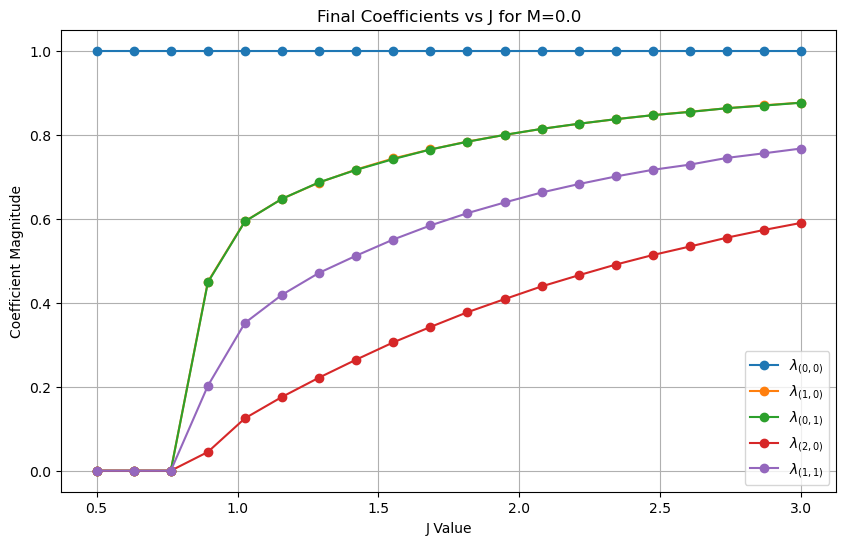

In [39]:
coeff_fig = plot_coefficients(results)
plt.show()

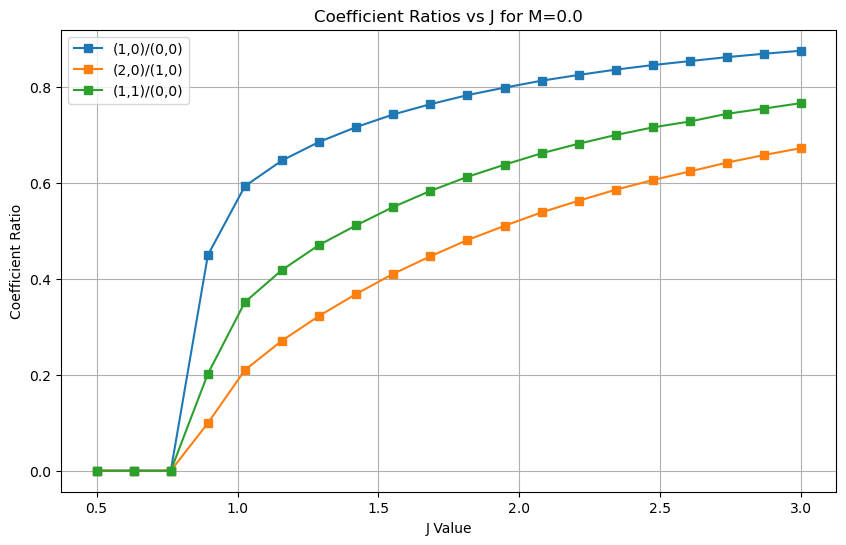

In [41]:
ratio_fig = plot_ratios(results)
plt.show()

In [ ]:
villain_deviation_fig = plot_villain_deviation(results)
plt.show()

/var/folders/56/k5k1hn6s4pd9x__t6s6fpclr0000gn/T/ipykernel_46753/2646739218.py:32: RuntimeWarning: invalid value encountered in scalar divide
  ratio_c20_c10[i] = norm_coeffs[i, 3] / norm_coeffs[i, 1]  # (2,0)/(1,0)


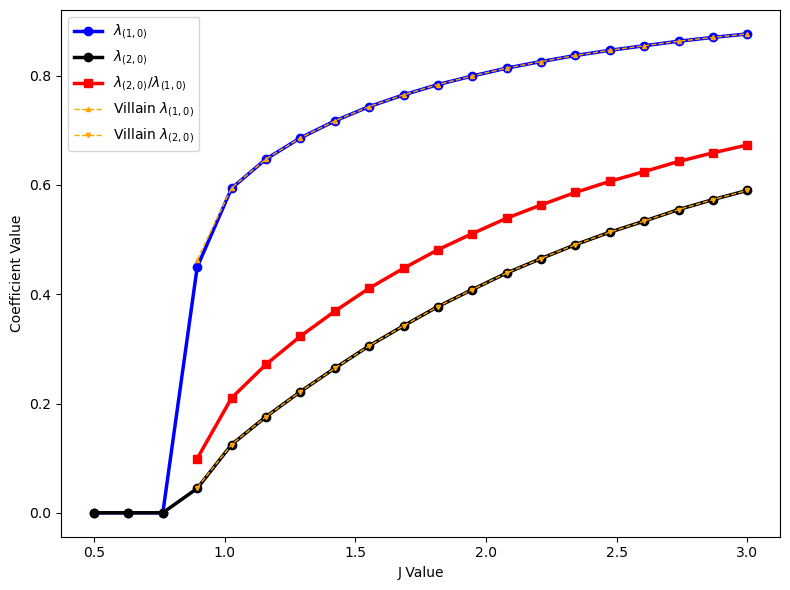

In [106]:
villain_comparison_fig = plot_villain_comparison(results)
plt.show()

#

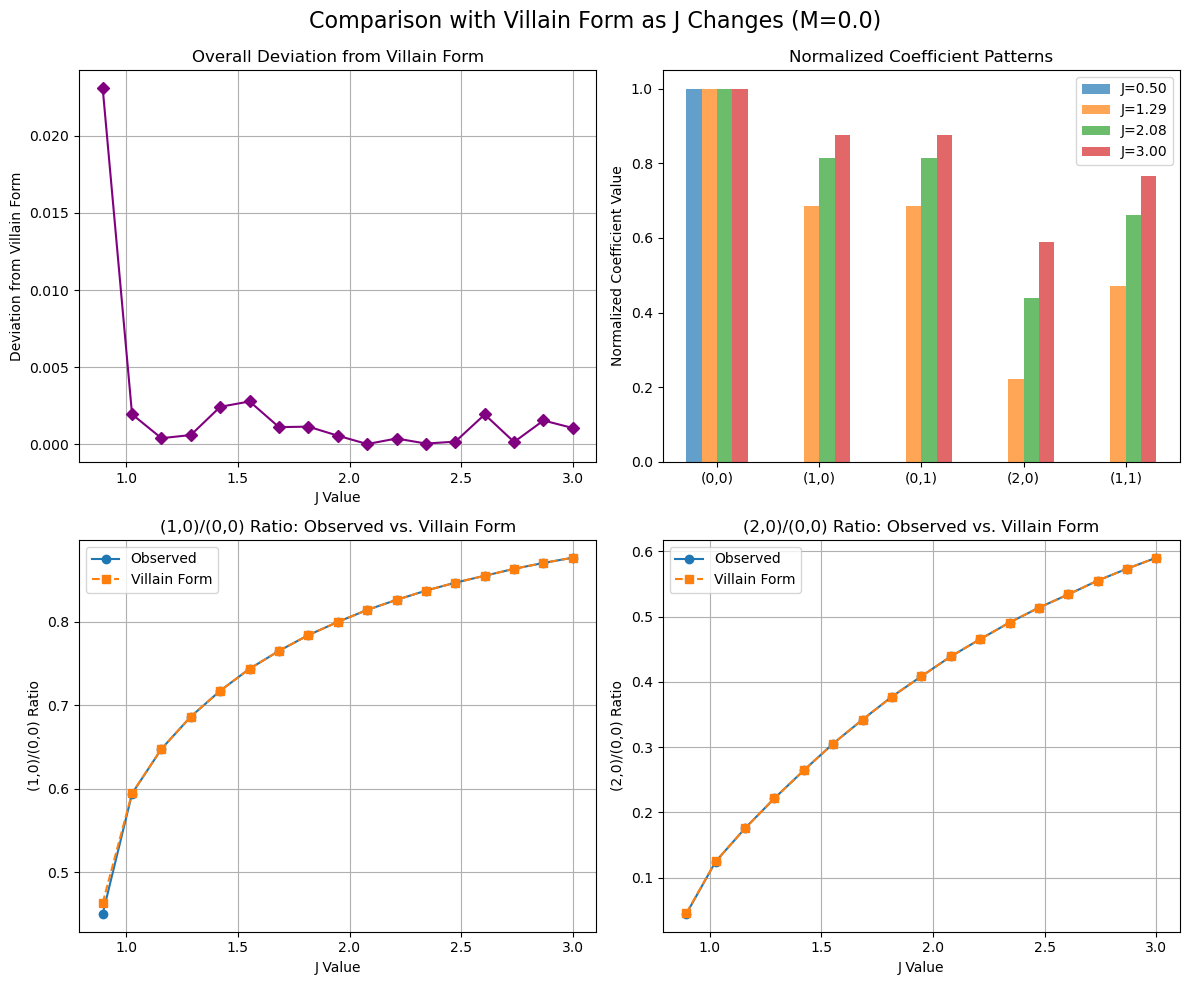

In [88]:
def plot_villain_comparison(results, figsize=(12, 10)):
    """
    Plot a detailed comparison between observed coefficients and the Villain form
    as J changes.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_J
        figsize: Figure size tuple (default: (12, 10))
        
    Returns:
        Matplotlib figure
    """
    J_values = results['J_values']
    M = results['M']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Comparison with Villain Form as J Changes (M={M})', fontsize=16)
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # Plot 1: Villain deviation vs J (overview)
    villain_deviation = results['villain_deviation']
    valid_indices = ~np.isnan(villain_deviation)
    
    if np.any(valid_indices):
        axes[0].plot(J_values[valid_indices], villain_deviation[valid_indices], 'D-', color='purple')
    
    axes[0].set_xlabel('J Value')
    axes[0].set_ylabel('Deviation from Villain Form')
    axes[0].set_title('Overall Deviation from Villain Form')
    axes[0].grid(True)
    
    # Plot 2: Coefficient patterns for selected J values
    # Choose indices for a few representative J values
    n_samples = min(4, len(J_values))
    sample_indices = np.linspace(0, len(J_values)-1, n_samples, dtype=int)
    
    width = 0.6 / n_samples  # Bar width
    x_positions = np.arange(len(coeff_labels))
    
    for i, idx in enumerate(sample_indices):
        J = J_values[idx]
        # Normalize coefficients by (0,0)
        if coefficients[idx, 0] > 1e-10:
            norm_coeffs = coefficients[idx] / coefficients[idx, 0]
        else:
            norm_coeffs = coefficients[idx]
            
        axes[1].bar(x_positions + i*width, norm_coeffs, width, 
                   label=f'J={J:.2f}', alpha=0.7)
    
    axes[1].set_xticks(x_positions + width*(n_samples-1)/2)
    axes[1].set_xticklabels(coeff_labels)
    axes[1].set_ylabel('Normalized Coefficient Value')
    axes[1].set_title('Normalized Coefficient Patterns')
    axes[1].legend()
    
    # Plot 3: Detailed comparison for specific coefficients
    # For each J value, calculate the Villain form and plot comparison
    # Focus on two key coefficients: (1,0) and (2,0)
    
    # Extract key coefficients
    ratio_c10_c00 = np.zeros_like(J_values)
    ratio_c20_c10 = np.zeros_like(J_values)
    ratio_c20_c00 = np.zeros_like(J_values)
    
    for i in range(len(J_values)):
        if coefficients[i, 0] > 1e-10:
            ratio_c10_c00[i] = coefficients[i, 1] / coefficients[i, 0]
            ratio_c20_c00[i] = coefficients[i, 3] / coefficients[i, 0]
        if coefficients[i, 1] > 1e-10:
            ratio_c20_c10[i] = coefficients[i, 3] / coefficients[i, 1]
    
    # For each J value with valid data, calculate expected Villain ratios
    villain_ratio_c10_c00 = np.zeros_like(J_values)
    villain_ratio_c20_c00 = np.zeros_like(J_values)
    
    for i in range(len(J_values)):
        if ratio_c20_c10[i] > 0:
            # Estimate Jv from the observed ratio
            Jv = -3 / (2 * np.log(ratio_c20_c10[i]))
            
            # Calculate expected ratios for Villain form
            villain_ratio_c10_c00[i] = np.exp(-1/(2*Jv))
            villain_ratio_c20_c00[i] = np.exp(-4/(2*Jv))
    
    # Plot observed vs. Villain expected for (1,0)/(0,0)
    valid = (villain_ratio_c10_c00 > 0) & (ratio_c10_c00 > 0)
    axes[2].plot(J_values[valid], ratio_c10_c00[valid], 'o-', label='Observed')
    axes[2].plot(J_values[valid], villain_ratio_c10_c00[valid], 's--', label='Villain Form')
    axes[2].set_xlabel('J Value')
    axes[2].set_ylabel('(1,0)/(0,0) Ratio')
    axes[2].set_title('(1,0)/(0,0) Ratio: Observed vs. Villain Form')
    axes[2].grid(True)
    axes[2].legend()
    
    # Plot observed vs. Villain expected for (2,0)/(0,0)
    valid = (villain_ratio_c20_c00 > 0) & (ratio_c20_c00 > 0)
    axes[3].plot(J_values[valid], ratio_c20_c00[valid], 'o-', label='Observed')
    axes[3].plot(J_values[valid], villain_ratio_c20_c00[valid], 's--', label='Villain Form')
    axes[3].set_xlabel('J Value')
    axes[3].set_ylabel('(2,0)/(0,0) Ratio')
    axes[3].set_title('(2,0)/(0,0) Ratio: Observed vs. Villain Form')
    axes[3].grid(True)
    axes[3].legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig

villain_comparison_fig = plot_villain_comparison(results)
plt.show()